<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/VAE_Linear_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from einops import rearrange
import time
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("mps")
print(torch.backends.mps.is_available(), torch.backends.mps.is_built(), device)

True True mps


In [4]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5],std=[0.5])])
dataset = datasets.MNIST(root="/Users/bin.guanb/code/MachineL/dataset/", transform=trans, download=True, train=True) # 6W张图片, 10种分类
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(len(dataset.classes), len(dataset), image.shape) # 10; 6W; 100,1,28,28

trans_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5],std=[0.5])])
dataset_test = datasets.MNIST(root="/Users/bin.guanb/code/MachineL/dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
print(len(dataset_test))

10 60000 torch.Size([100, 1, 28, 28])
10000


In [25]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(28*28,256), nn.ReLU(), nn.Linear(256, 2*2))
    self.decoder = nn.Sequential(nn.Linear(2,256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid())

  def reparam(self, mu, logvar):
    epsilon = torch.randn_like(mu)
    return mu + epsilon * torch.exp(logvar/2)

  def forward(self, x):
    x = x.view(x.shape[0], -1) # ,28*28
    h = self.encoder(x) # ,2*2
    mu, logvar = h.chunk(2, dim=1) # ,2  + ,2
    h = self.reparam(mu, logvar) #,2
    out = self.decoder(h)
    out = rearrange(out, 'b (h w) -> b 1 h w', h=28)
    return out, mu, logvar

model = Net().to(device)
#print(model)
model_cpu = Net().to("cpu")
#summary(model_cpu, (28,28))

kl_loss = lambda mu, logvar : -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
gen_loss = lambda gen, x : F.binary_cross_entropy(gen, x, size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

epoch:1 batch:299 loss:-50585.86 mean:-52901.47 time:3.3


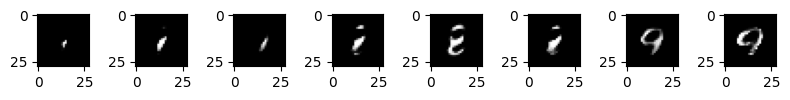

epoch:1 batch:599 loss:-51198.18 mean:-52850.12 time:3.4


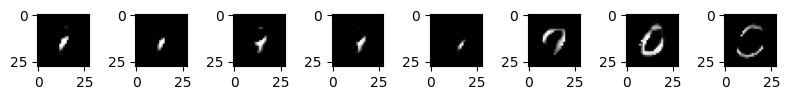

epoch:2 batch:299 loss:-52071.06 mean:-52904.65 time:3.3


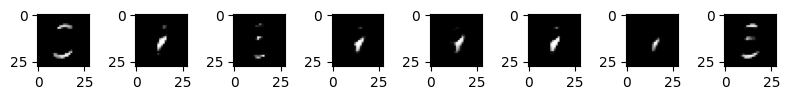

epoch:2 batch:599 loss:-52699.20 mean:-52902.14 time:3.2


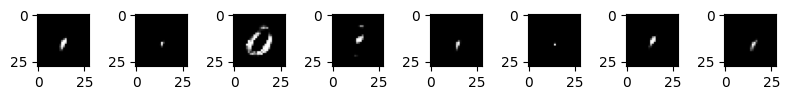

epoch:3 batch:299 loss:-52739.52 mean:-52945.47 time:3.2


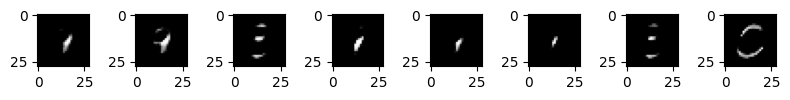

epoch:3 batch:599 loss:-51072.96 mean:-52945.76 time:3.3


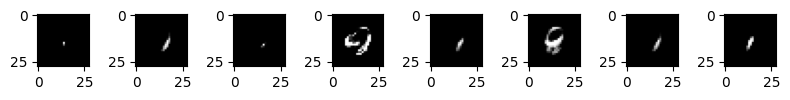

epoch:4 batch:299 loss:-51371.23 mean:-53013.97 time:3.3


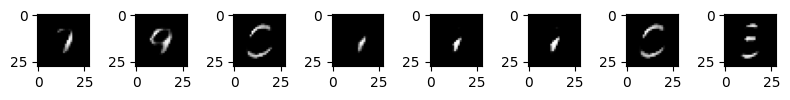

epoch:4 batch:599 loss:-51796.81 mean:-52989.65 time:3.2


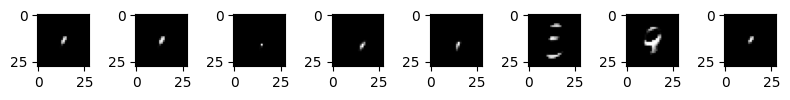

epoch:5 batch:299 loss:-51343.18 mean:-52939.38 time:3.3


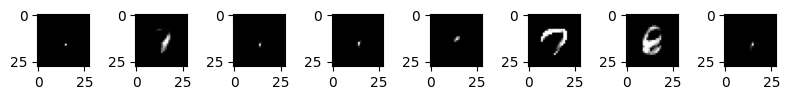

epoch:5 batch:599 loss:-52703.04 mean:-53022.16 time:3.2


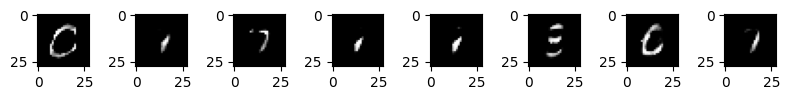

epoch:6 batch:299 loss:-50655.37 mean:-52972.54 time:3.2


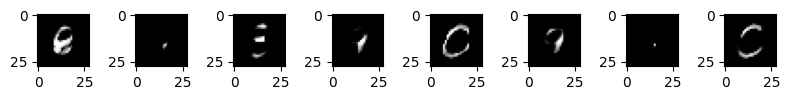

epoch:6 batch:599 loss:-54493.22 mean:-53061.52 time:3.2


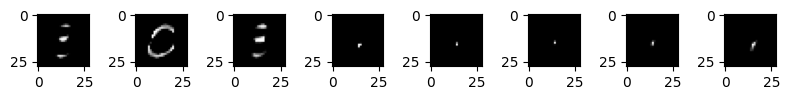

epoch:7 batch:299 loss:-54359.02 mean:-53026.41 time:3.2


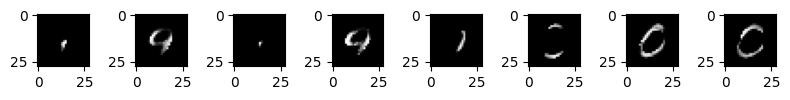

epoch:7 batch:599 loss:-52858.05 mean:-53084.56 time:3.2


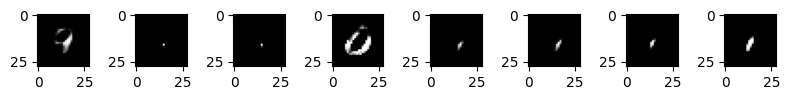

epoch:8 batch:299 loss:-54183.42 mean:-53100.17 time:3.2


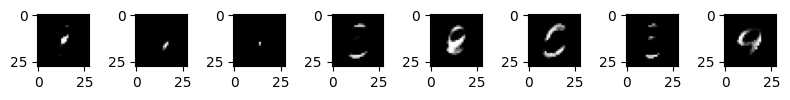

epoch:8 batch:599 loss:-53156.92 mean:-53142.00 time:3.2


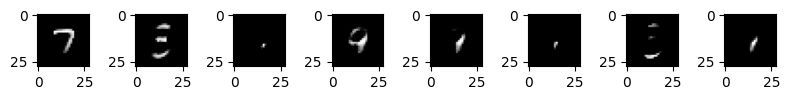

epoch:9 batch:299 loss:-52394.86 mean:-53091.22 time:3.2


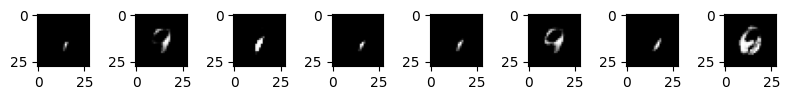

epoch:9 batch:599 loss:-50156.64 mean:-53194.92 time:3.2


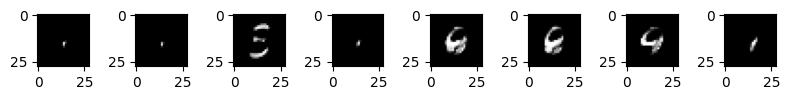

epoch:10 batch:299 loss:-53038.90 mean:-53162.09 time:3.2


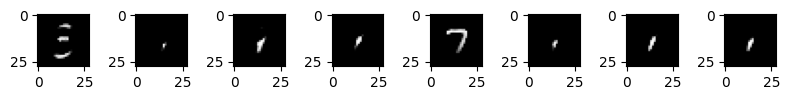

epoch:10 batch:599 loss:-55609.14 mean:-53219.35 time:3.2


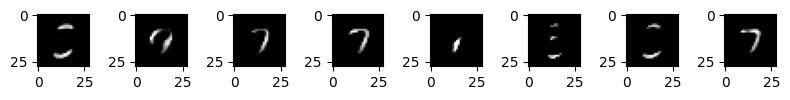

epoch:11 batch:299 loss:-51324.05 mean:-53243.71 time:3.1


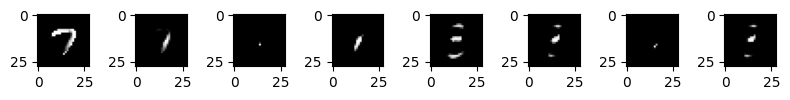

epoch:11 batch:599 loss:-52093.71 mean:-53247.31 time:3.2


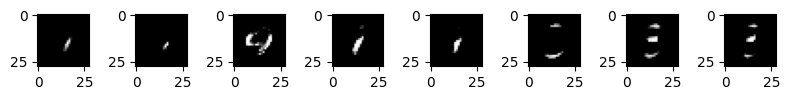

epoch:12 batch:299 loss:-51376.62 mean:-53196.75 time:3.2


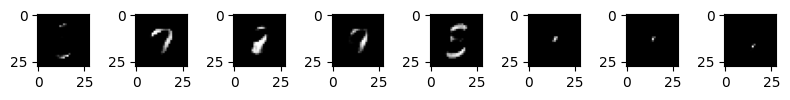

epoch:12 batch:599 loss:-54174.35 mean:-53307.28 time:3.2


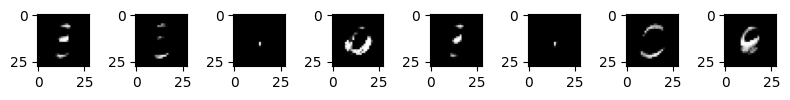

epoch:13 batch:299 loss:-55004.84 mean:-53273.62 time:3.1


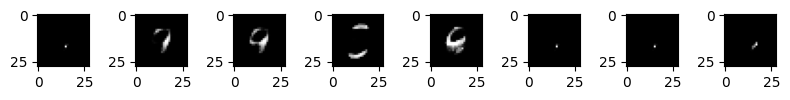

epoch:13 batch:599 loss:-52543.33 mean:-53326.17 time:3.2


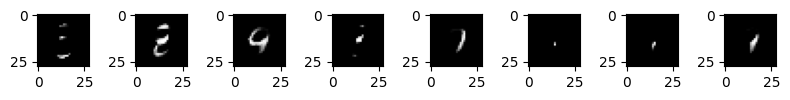

epoch:14 batch:299 loss:-52653.27 mean:-53379.83 time:3.2


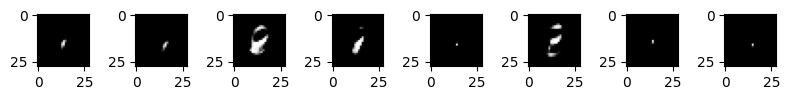

epoch:14 batch:599 loss:-50815.40 mean:-53360.71 time:3.2


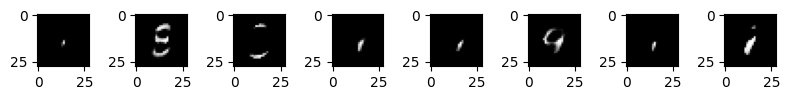

epoch:15 batch:299 loss:-56211.39 mean:-53402.18 time:3.2


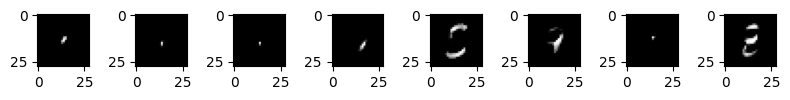

epoch:15 batch:599 loss:-53810.54 mean:-53399.89 time:3.2


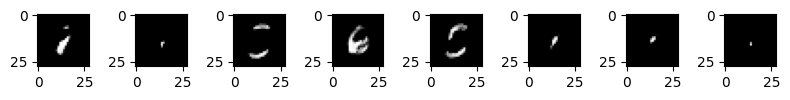

epoch:16 batch:299 loss:-54058.23 mean:-53387.23 time:3.2


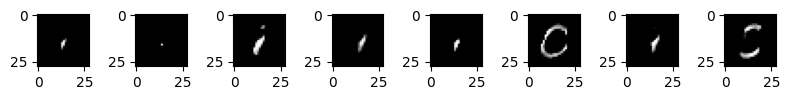

epoch:16 batch:599 loss:-55516.13 mean:-53432.58 time:3.2


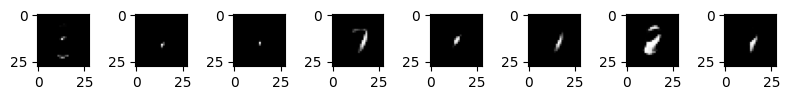

epoch:17 batch:299 loss:-54338.37 mean:-53524.95 time:3.1


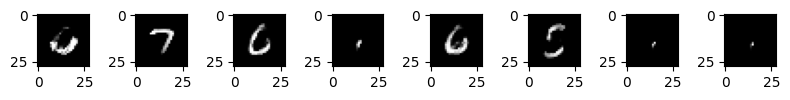

epoch:17 batch:599 loss:-52725.15 mean:-53476.78 time:3.2


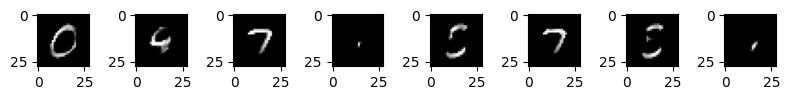

epoch:18 batch:299 loss:-53360.32 mean:-53428.42 time:3.2


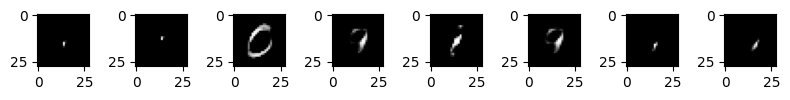

epoch:18 batch:599 loss:-52793.66 mean:-53476.43 time:3.2


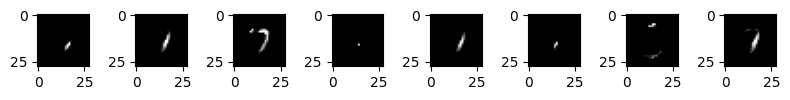

epoch:19 batch:299 loss:-54028.30 mean:-53412.30 time:3.2


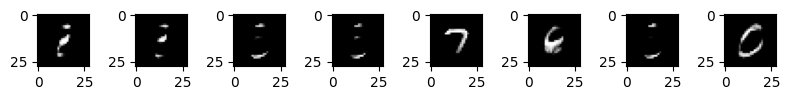

epoch:19 batch:599 loss:-53946.40 mean:-53515.00 time:3.4


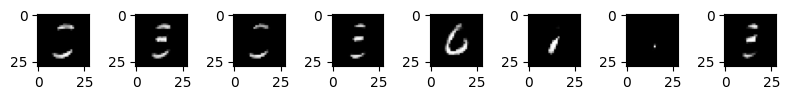

In [29]:
for epoch in range(1,20):
  total_loss = []
  startTime = time.time()
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    gen_img, mu, logvar = model(img)

    genLoss = gen_loss(gen_img, img)
    klLoss = kl_loss(mu, logvar)
    loss = (genLoss + klLoss) / 100

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())

    if(batch_idx % 300 == 299):
      print("epoch:{} batch:{} loss:{:.2f} mean:{:.2f} time:{:.1f}".format(
          epoch, batch_idx, loss, np.mean(total_loss), time.time()-startTime))
      with torch.no_grad():
        fig, axs = plt.subplots(1, 8, figsize=(8, 1))
        for i, ax in enumerate(axs.flatten()):
          ax.imshow(gen_img[i][0].cpu(), cmap='gray')
        plt.tight_layout()
        plt.show()

      startTime = time.time()